# 応用統計学 レポート
03-190599  
長谷川 貴大

# PC環境
- MacBook Pro (13-inch, 2016, Two Thunderbolt 3 ports)
- 2 GHz Intel Core i5
- 8 GB 1867 MHz LPDDR3

# プログラミング環境
- Python3.6
- 使用するモジュールは以下の通り
- ただし、問題1の乱数生成は、筆者が実装した乱数生成器を用いる

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib
%matplotlib inline

from io import BytesIO
from PIL import Image
from mpl_toolkits.mplot3d import Axes3D

from tqdm import tqdm_notebook as tqdm
import numpy as np
import scipy.stats as st
import random
from datetime import datetime
import pandas as pd
from operator import itemgetter

from sklearn.datasets import load_boston

import warnings
warnings.filterwarnings('ignore')
import gc

# 問題1

## 擬似乱数の比較
モンテカルロ法において、擬似乱数の乱数度が計算精度に最も影響する。  
そこで、pythonで利用可能な各乱数と、独自に作成したメルセンヌ・ツイスタ（MT19937)を比較する。  
比較手法として、標準偏差で等頻度性を、連検定で無規則性を評価する。
10,000個の乱数を生成し、評価することを10回繰り返す。

---

### 連検定
ある基準値$v$よりも大きい要素を$p$、小さい要素を$n$と符号化する。
$p$または$n$が連続する部分を「連」という。連の数を$K$とする。
$p$の個数を$P$、$n$の個数を$N$とする。
$\mu$と$\sigma$を以下のようにとる。

$$\mu=\frac{2PN}{P+N}+1$$

$$\sigma=\frac{2PN\left( 2PN-P-N\right) }{\left( P+N\right)^2\left( P+N-1\right) }$$

このとき、$K$は、平均$\mu$、分散$\sigma$の正規分布に従うことが知られている。
これを用いると、統計的検定によって、連の数が多すぎる場合と少なすぎる場合を棄却できる。

In [2]:
# https://medium.com/@sddkal/runs-test-implementation-in-python-6236b0a2b433
def runs_test(d, v, alpha = 0.05):
    # Get positive and negative values
    mask = d > v
    # get runs mask
    p = mask == True
    n = mask == False
    xor = np.logical_xor(p[:-1], p[1:]) 
    # A run can be identified by positive 
    # to negative (or vice versa) changes
    d = sum(xor) + 1 # Get number of runs

    n_p = sum(p) # Number of positives
    n_n = sum(n)
    # Temporary intermediate values
    tmp = 2 * n_p * n_n 
    tmps = n_p + n_n
    # Expected value
    r_hat = np.float64(tmp) / tmps + 1
    # Variance
    s_r = (np.sqrt(tmp)*np.sqrt(tmp - tmps)) / (tmps*np.sqrt(tmps-1))
    # Standard deviation
    #s_r =  np.sqrt(s_r_squared)
    # Test score
    z = (d - r_hat) / s_r

    # Get normal table 
    z_alpha = st.norm.ppf(1-alpha)
    # Check hypothesis
    return z

---


### メルセンヌ・ツイスタ（Mersenne twister）
松本眞と西村拓士によって開発された擬似乱数列生成器。
多くのプログラミング言語で利用されている。
MT19937には以下の特徴がある。
- $2^{19937}-1$の長周期である
- $623$次元に均等に分布する

公開されているアルゴリズムをpythonに変換する。

In [3]:
MT = [0 for i in range(624)]
index = 0

# To get last 32 bits
bitmask_1 = (2 ** 32) - 1

# To get 32. bit
bitmask_2 = 2 ** 31

# To get last 31 bits
bitmask_3 = (2 ** 31) - 1

def initialize_generator(seed):
    "Initialize the generator from a seed"
    global MT
    global bitmask_1
    MT[0] = seed
    for i in range(1,624):
        MT[i] = ((1812433253 * MT[i-1]) ^ ((MT[i-1] >> 30) + i)) & bitmask_1


def extract_number():
    """
    Extract a tempered pseudorandom number based on the index-th value,
    calling generate_numbers() every 624 numbers
    """
    global index
    global MT
    if index == 0:
        generate_numbers()
    y = MT[index]
    y ^= y >> 11
    y ^= (y << 7) & 2636928640
    y ^= (y << 15) & 4022730752
    y ^= y >> 18

    index = (index + 1) % 624
    return y

def generate_numbers():
    "Generate an array of 624 untempered numbers"
    global MT
    for i in range(624):
        y = (MT[i] & bitmask_2) + (MT[(i + 1 ) % 624] & bitmask_3)
        MT[i] = MT[(i + 397) % 624] ^ (y >> 1)
        if y % 2 != 0:
            MT[i] ^= 2567483615

---

以下では各乱数に対して連検定をおこなう。  

In [4]:
n=52
#0~nまでの整数の乱数を生成

trial=624*2
#乱数生成を繰り返す回数

repeat=10000
#評価を繰り返す回数

alpha=0.05
#棄却域

now = datetime.now()
initialize_generator(now.microsecond)

In [5]:
std_list=[]
z_list=[]

### MT: メルセンヌ・ツイスタ（直接除算）
$0$〜$2^{32}$の整数で出力される乱数を、指定された範囲に限定する際に、$2^{32}$の除算を行い、$0$〜$1$に基準化した値を用いる。

In [6]:
std_temp=[]
z_temp=[]

for k in range(repeat):
    random_list=[]
    for i in range(trial):
        temp = extract_number()
        random_list.append(np.floor(temp/bitmask_1*n)+1)

    random_list = np.array(random_list)
    std_temp.append(np.std(random_list))
    z = runs_test(random_list, np.median(random_list), alpha)
    z_temp.append(z)
    
    if np.abs(z)>st.norm.ppf(1-alpha):
        print("x", end="")
        
std_list += std_temp
z_list += z_temp

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

### MT_mod: メルセンヌ・ツイスタ（剰余）
$0$〜$2^{32}$の整数で出力される乱数を、指定された範囲に限定する際に、剰余を用いる。

In [7]:
std_temp=[]
z_temp=[]

for k in range(repeat):
    random_list=[]

    for i in range(trial):
        temp = extract_number()
        random_list.append(temp%n + 1)

    random_list = np.array(random_list)
    std_temp.append(np.std(random_list))
    z = runs_test(random_list, np.median(random_list), alpha)
    z_temp.append(z)
    
    if np.abs(z)>st.norm.ppf(1-alpha):
        print("x", end="")
        
std_list += std_temp
z_list += z_temp

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

### MT_adjust: メルセンヌ・ツイスタ（採択乱数の調整）
指定された範囲の長さで割り切れる最大値より大きい値が出力された場合、乱数を取り直すことで、等頻度性を向上させる。

In [8]:
std_temp=[]
z_temp=[]

adjusted_max = (bitmask_1) - (bitmask_1) % n
for k in range(repeat):
    random_list=[]

    for i in range(trial):
        temp = extract_number()
        while(temp>=adjusted_max):
            temp = extract_number()
        random_list.append(np.floor(temp/adjusted_max*n)+1)

    random_list = np.array(random_list)
    std_temp.append(np.std(random_list))
    z = runs_test(random_list, np.median(random_list), alpha)
    z_temp.append(z)
    
    if np.abs(z)>st.norm.ppf(1-alpha):
        print("x", end="")
        
std_list += std_temp
z_list += z_temp

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

### numpy.random.randint

In [9]:
std_temp=[]
z_temp=[]

for k in range(repeat):
    random_list = np.random.randint(1,n+1,trial)
    
    std_temp.append(np.std(random_list))
    z = runs_test(random_list, np.median(random_list), alpha)
    z_temp.append(z)
    
    if np.abs(z)>st.norm.ppf(1-alpha):
        print("x", end="")
        
std_list += std_temp
z_list += z_temp

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

### random.randint

In [10]:
std_temp=[]
z_temp=[]

for k in range(repeat):
    random_list = [random.randint(1, n) for i in range(trial)]
    
    std_temp.append(np.std(random_list))
    z = runs_test(random_list, np.median(random_list), alpha)
    z_temp.append(z)
    
    if np.abs(z)>st.norm.ppf(1-alpha):
        print("x", end="")
        
std_list += std_temp
z_list += z_temp

xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

In [11]:
std_df = pd.DataFrame(np.array(std_list).T, columns=["std"])
std_df["id"] = ["MT"]*repeat+["MT_mod"]*repeat+["MT_adjust"]*repeat+["Numpy"]*repeat+["random"]*repeat
z_df = pd.DataFrame(np.array(z_list).T, columns=["z"])
z_df["id"] = ["MT"]*repeat+["MT_mod"]*repeat+["MT_adjust"]*repeat+["Numpy"]*repeat+["random"]*repeat

以下の分布図は、生成乱数の標準偏差である。全体的に値が小さく、且つばらつきも小さいものが良い。

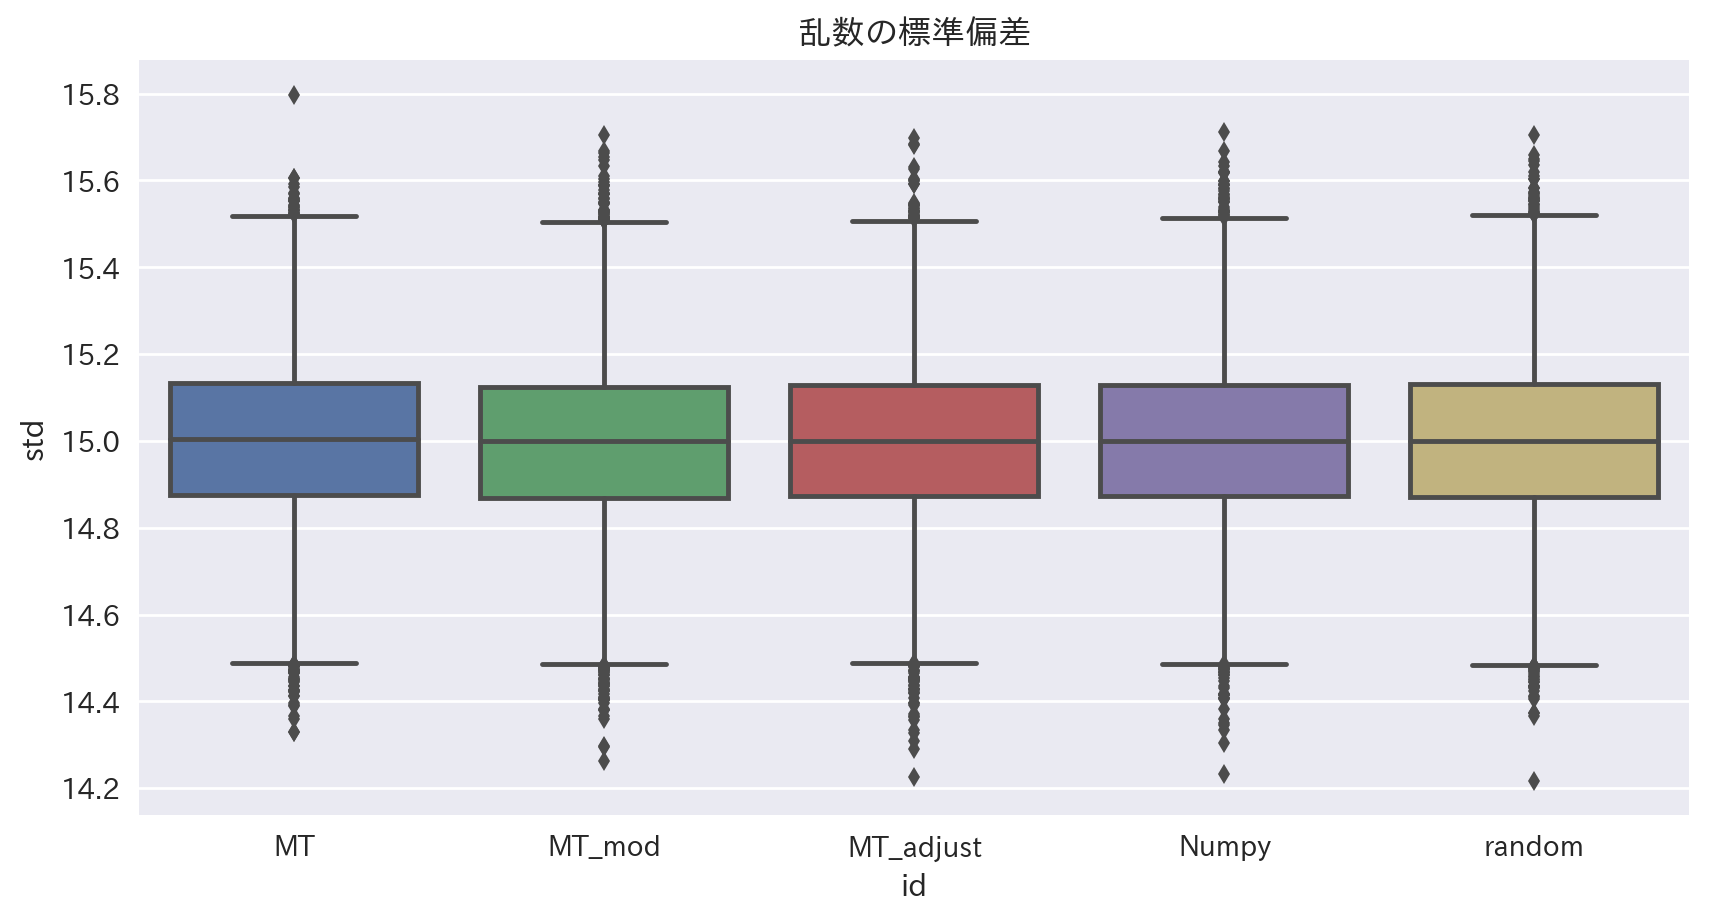

In [42]:
plt.figure(figsize=(10,5),dpi=200)
plt.title("乱数の標準偏差")
#sns.swarmplot(x=std_df["id"], y =std_df["std"],alpha=0.5)
sns.boxplot(x=std_df["id"], y =std_df["std"])
plt.show()

以下の箱ひげ図は、乱数が無規則であることを帰無仮説とした検定統計量である。はらつきが小さく、0付近に集まっているものが良い。

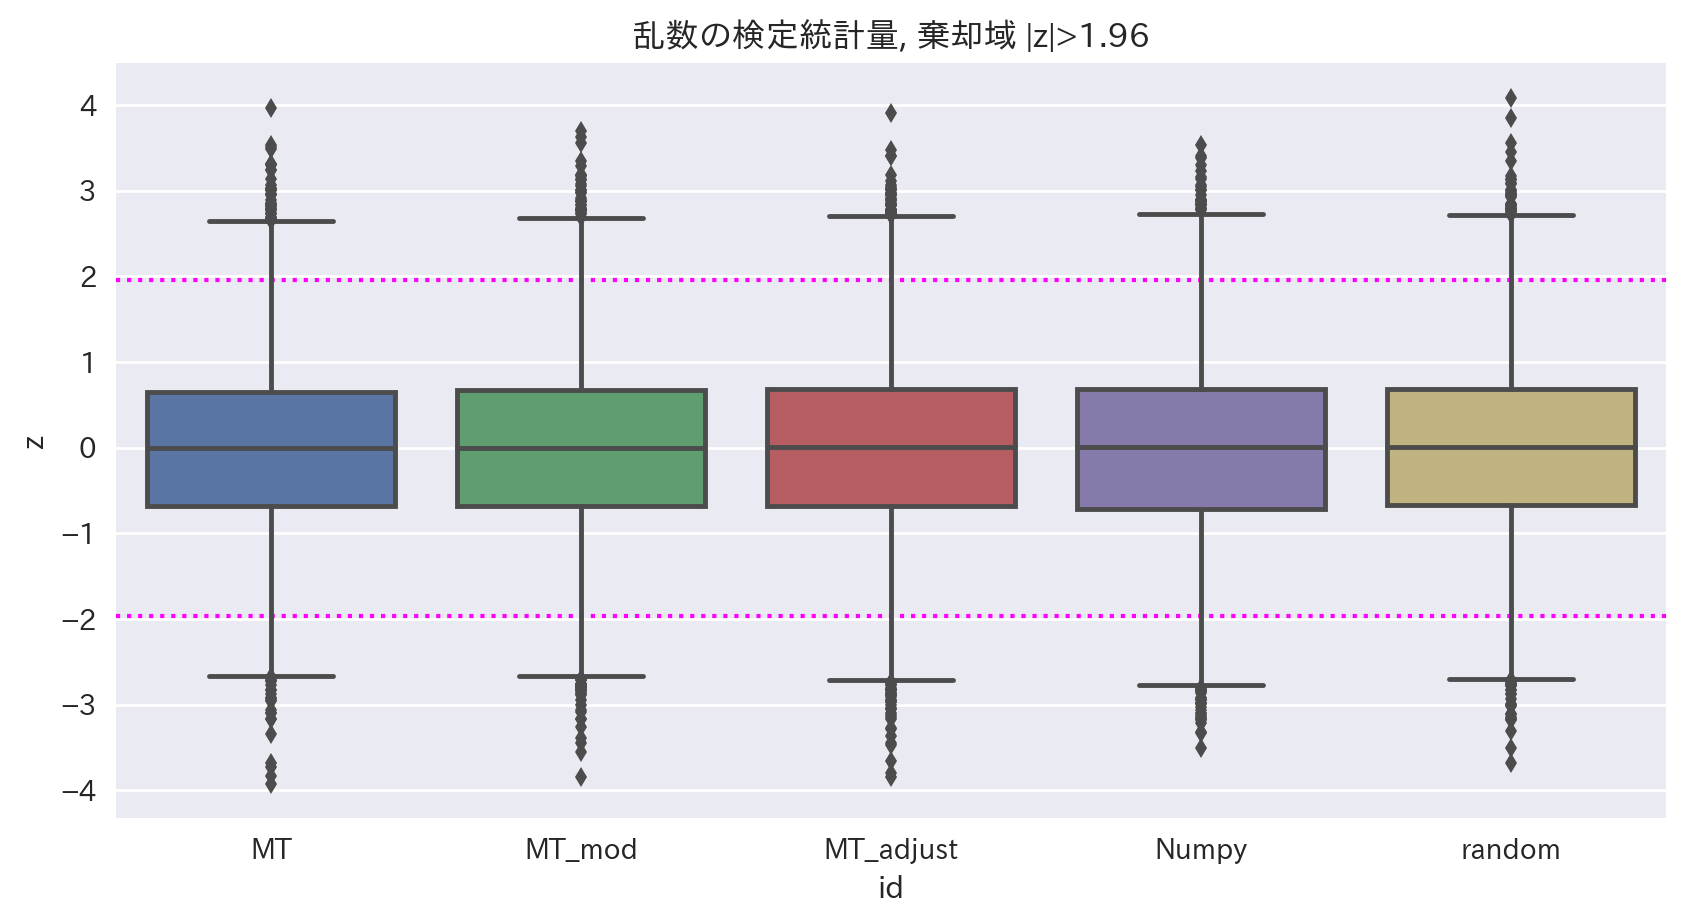

In [43]:
plt.figure(figsize=(10,5),dpi=200)
plt.title("乱数の検定統計量, 棄却域 |z|>1.96")
plt.axhline(1.96, ls = ":", color = "magenta", linewidth=1.5)
plt.axhline(-1.96, ls = ":", color = "magenta", linewidth=1.5)
#sns.swarmplot(x=z_df["id"], y =z_df["z"],alpha=0.5)
sns.boxplot(x=z_df["id"], y =z_df["z"])
plt.show()

結果に大差は無かった。独自に作成したMT_adjudtを使用する。以下に、$s$以上$t$未満の整数乱数を$n$個与える関数を定義する。

In [14]:
def mt_adjust(s,t,n):
    random_list=[]
    for i in range(n):
        adjusted_max = (bitmask_1) - (bitmask_1) % (t-s)
        temp = extract_number()
        while(temp>=adjusted_max):
            temp = extract_number()
            
        if n == 1:
            return int(np.floor(temp/adjusted_max*(t-s))+s)
        
        random_list.append(int(np.floor(temp/adjusted_max*(t-s))+s))
    return random_list

---

乱数は、値が重複しうるため、並べ替えには不適切である。  
そこで、フィッシャー・イェーツのアルゴリズムによって、乱数で配列を並び替えることで、重複無しの乱数を得る。  
0~n-1のインデックスを持つn要素の配列Aに対し、以下の操作を行う。
1. i = n-1
2. j = 0~iの範囲の整数乱数
3. A[i]とA[j]を入れ替える
4. i = i-1として2. に戻る

In [15]:
def Fisher_Yates_shuffle(int_list):
    for i in range(len(int_list))[::-1]:
        j = mt_adjust(0,i+1,1)
        int_list[i], int_list[j] = int_list[j], int_list[i]
        
    return int_list

### 本題
5枚選ぶタイミングで毎回シャッフルする試行は、最初に1回だけシャッフルして上から順番に取っていく試行と本質的に同じである。（なぜなら、シャッフルは一様ランダムだからである。）  
計算機上でも、これらのアルゴリズムが同じ結果を与えるかを確かめる。  
2,000,000回のモンテカルロ法を実行する。10,000回ごとに、それぞれのアルゴリズムにおける期待値が統計的に等しいかの検定を行う。

In [16]:
itr=2000000

5枚選ぶタイミングで毎回シャッフルするとして計算する場合。

In [17]:
def play_game_1():
    cards=list(range(13))*4
    num_card=len(cards)
    i=1
    while(True):
        if num_card <= 2:
            return 20

        choice_num = Fisher_Yates_shuffle(list(range(num_card)))[-5:]
        choice_cards = itemgetter(*choice_num)(cards)
        if len(choice_cards) > len(set(choice_cards)):
            return i

        cards = [item for index, item in enumerate(cards) if index not in choice_num]
        num_card-=len(choice_num)
        i+=1

In [18]:
score1=[]
mean1_list=[]
var1_list=[]
for i in tqdm(range(itr)):
    score1.append(play_game_1())
    
    if i%10000==9999:
        mean1_list.append(np.mean(score1))
        var1_list.append(np.var(score1))

mean1 = np.sum(score1)/itr
se1 = np.sqrt(np.sum(np.power(score1,2))/itr - mean1**2)/np.sqrt(itr)
print(f"期待値: {mean1}")
print(f"標準誤差: {se1}")

Widget Javascript not detected.  It may not be installed or enabled properly.



期待値: 2.055746
標準誤差: 0.0011252191749797013


---

最初にシャッフルした順番に引いていく場合。

In [19]:
def play_game_2():
    cards=list(range(13))*4
    num_card=len(cards)
    choice_num = Fisher_Yates_shuffle(list(range(num_card)))
    i=1
    while(True):
        if num_card <= 2:
            return 20

        choice_cards = itemgetter(*choice_num[5*(i-1):5*i])(cards)
        if len(choice_cards) > len(set(choice_cards)):
            return i

        num_card-=5
        i+=1

In [20]:
score2=[]
mean2_list=[]
var2_list=[]
for i in tqdm(range(itr)):
    score2.append(play_game_2())
    
    if i%10000==9999:
        mean2_list.append(np.mean(score2))
        var2_list.append(np.var(score2))

mean2 = np.sum(score2)/itr
se2 = np.sqrt(np.sum(np.power(score2,2))/itr - mean2**2)/np.sqrt(itr)
print(f"期待値: {mean2}")
print(f"標準誤差: {se2}")

Widget Javascript not detected.  It may not be installed or enabled properly.



期待値: 2.0566195
標準誤差: 0.001123479357224633


---

以下の図は、2つのアルゴリズムの期待値の推移である。  
有効桁数3桁の精度で収束していることがわかる。

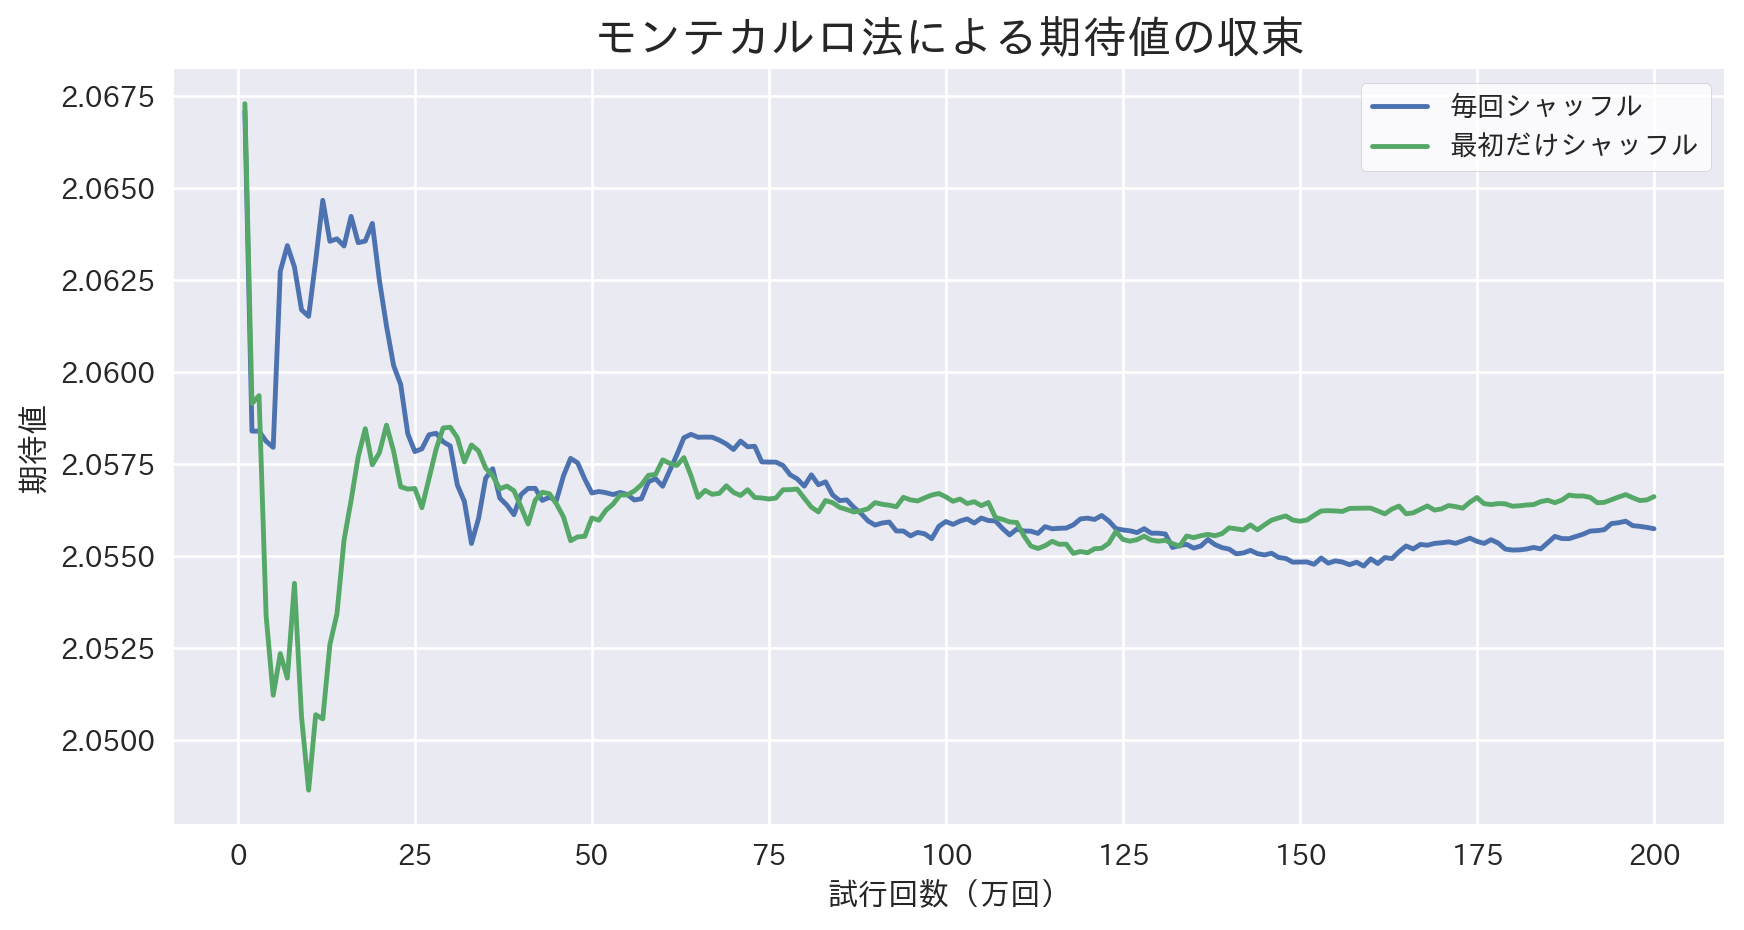

In [21]:
plt.figure(figsize=(10,5),dpi=200)
plt.plot(list(range(1,len(mean1_list)+1)), mean1_list, label="毎回シャッフル")
plt.plot(list(range(1,len(mean2_list)+1)), mean2_list, label="最初だけシャッフル")
plt.title("モンテカルロ法による期待値の収束",fontsize=16)
plt.xlabel('試行回数（万回）')
plt.ylabel('期待値')
plt.legend(facecolor="white",frameon=True)

2つのアルゴリズムが等期待値であることの検定をおこなう。  
対応のないデータの2標本t検定を適用する。
参考：https://bellcurve.jp/statistics/course/9427.html

試行回数を増やしていっても、2つのアルゴリズムが同じ期待値を持たない可能性が十分にあることが懸念される。

In [22]:
t_list=[]
for i in range(int(itr/10000)):
    s2=((i+1)*10000*var1_list[i]+(i+1)*10000*var2_list[i])/((i+1)*10000+(i+1)*10000-2)
    t=(mean1_list[i]-mean2_list[i])/np.sqrt(s2)/np.sqrt(2/(i+1)/10000)
    if t>0.5:
        t = 1-t
    t = 2*t
    t_list.append(st.t.cdf(t, df=(i+1)*10000+(i+1)*10000-2))

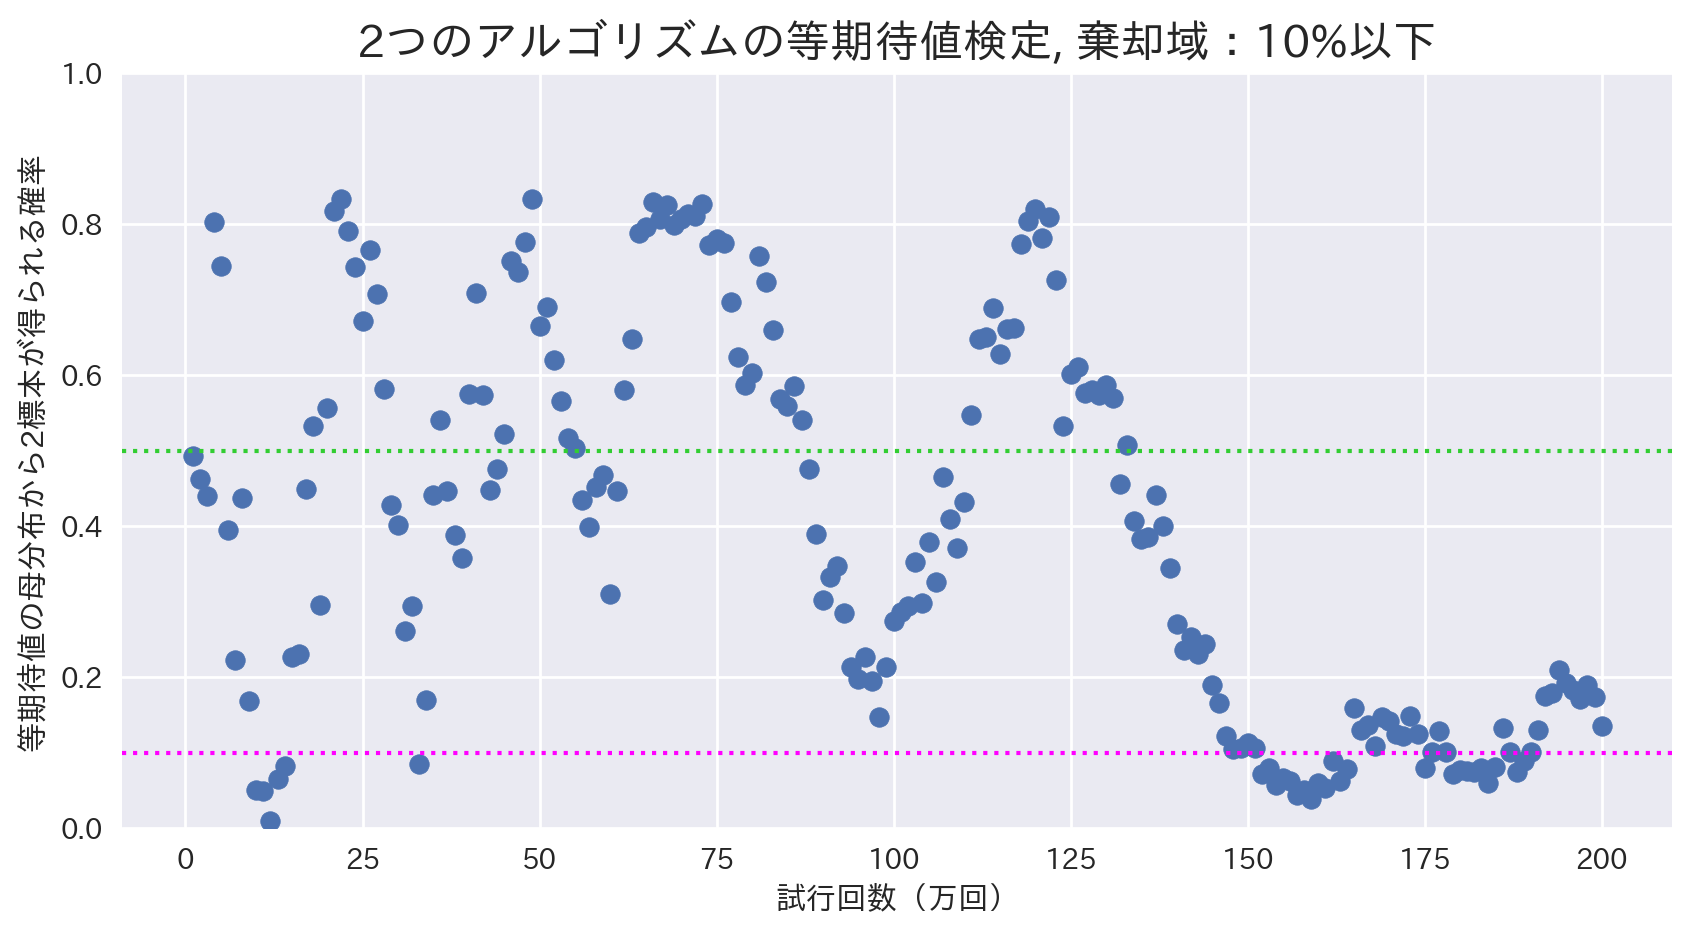

In [23]:
plt.figure(figsize=(10,5),dpi=200)
plt.title("2つのアルゴリズムの等期待値検定, 棄却域：10%以下",fontsize=16)
plt.xlabel('試行回数（万回）')
plt.ylabel('等期待値の母分布から2標本が得られる確率')
plt.ylim(0, 1)
plt.axhline(0.1, ls = ":", color = "magenta", linewidth=1.5)
plt.axhline(0.5, ls = ":", color = "limegreen", linewidth=1.5)
plt.scatter(list(range(1,len(mean1_list)+1)), t_list)

このように、本質的に同じアルゴリズムの等期待値性が主張しづらい背景には、このゲームのモンテカルロ法の収束が遅いことがあると予想される。  
このゲームは、ごくわずかな確率で非常に大きな値を得るfat tailな分布であることから、モンテカルロ法での期待値の収束の遅さと分布の裾の厚さには関係があることが予想される。  
また、毎回シャッフルした場合の方が、最初だけシャッフルした場合より期待値が大きい傾向がある点に疑義が残る。

有効桁数3桁の範囲では、毎回シャッフルするか否かで、結果は変わらないと言える。
計算時間の観点では、1度だけシャッフルする方が、毎回シャッフルする方の半分の時間で計算が終了した。計算機上では、毎回シャッフルせずに、順番にカードを引くアルゴリズムに変更して計算したほうが、コストが少ない。（しかし、ループが遅いPythonでは200万回の試行に9分程度を要する。）

# 問題2
scikit-learnモジュールに付属されているBoston house-pricesのデータを用いて、重回帰分析を行う。  
このデータセットは、住環境の指標を特徴量として、住宅価格を予測する目的で用いられる。

出典：https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html

In [24]:
boston = load_boston()
df = pd.DataFrame(boston.data, columns=boston.feature_names)
target = boston.target

In [25]:
df.shape

(506, 13)

説明変数が13項目のデータが506個ある。以下に最初の5データを示す。

In [26]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


各列の特徴量を以下に解説する。

|特徴量|解説|
|---|:--|
|CRIM|	人口 1 人当たりの犯罪発生数|
|ZN|	25,000 平方フィート以上の住居区画の占める割合|
|INDUS|	小売業以外の商業が占める面積の割合|
|CHAS|	チャールズ川によるダミー変数 (1: 川の周辺, 0: それ以外)|
|NOX|	NOx の濃度|
|RM|	住居の平均部屋数|
|AGE|	1940 年より前に建てられた物件の割合|
|DIS|	5 つのボストン市の雇用施設からの距離 (重み付け済)|
|RAD|	環状高速道路へのアクセスしやすさ|
|TAX|	$10,000 ドルあたりの不動産税率の総計|
|PTRATIO|	町毎の児童と教師の比率|
|B|	町毎の黒人 (Bk) の比率を次の式で表したもの。 1000(Bk – 0.63)^2|
|LSTAT|	給与の低い職業に従事する人口の割合 (%)|

従属変数は、オーナーが所有する住宅の価格の中央値（単位は1,000USD）である。以下に最初の5データを示す。

In [27]:
target[:5]

array([24. , 21.6, 34.7, 33.4, 36.2])

---

In [28]:
X = boston.data
y = target

従属変数の分布を以下に示す。  
22,000USD付近を中心とするすり鉢型である一方、40,000USD以上の高級住宅も一定数存在するfat tailな分布である。

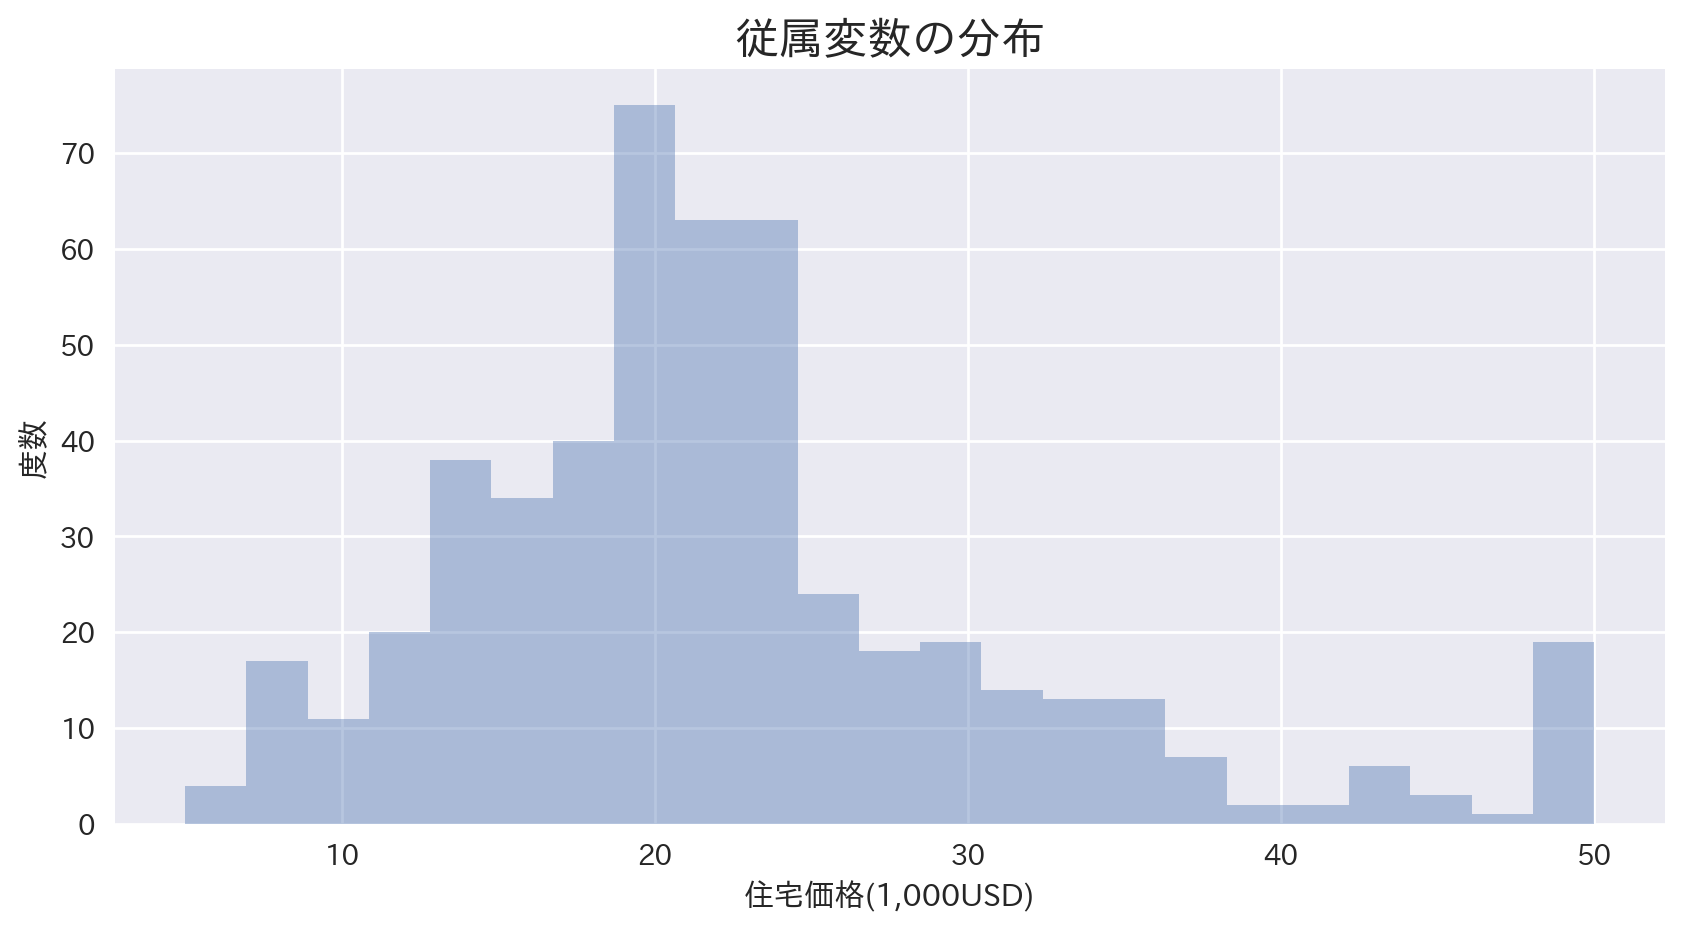

In [29]:
plt.figure(figsize=(10,5),dpi=200)
plt.title("従属変数の分布", fontsize=16)
plt.xlabel('住宅価格(1,000USD)')
plt.ylabel('度数')
sns.distplot(y, kde=False, rug=False) 

---

ガウスの消去法によって、正規方程式を解く。

In [30]:
def solve(mat,b):
    for i in range(len(mat)-1):
        for j in range(i+1, len(mat)):
            coef = mat[j][i] / mat[i][i]
            mat[j] -= mat[i] * coef
            b[j] -= b[i] * coef

    for i in range(len(mat)-1, -1, -1):
        b[i] /= mat[i][i]
        mat[i] /= mat[i][i]
        for j in range(i):
            b[j] -= b[i] * mat[j][i]
            mat[j][i] = 0 
            
    return b

In [31]:
reg = solve(np.dot(X.T,X),np.dot(X.T, y).T)

回帰係数は以下の通り。

In [32]:
print(np.round(reg,5))

[-9.16300e-02  4.86800e-02 -3.78000e-03  2.85637e+00 -2.88078e+00
  5.92521e+00 -7.22000e-03 -9.68000e-01  1.70440e-01 -9.39000e-03
 -3.92430e-01  1.49800e-02 -4.16970e-01]


決定係数は以下の通り。

In [33]:
np.linalg.norm(np.dot(X,reg)-np.mean(y))/np.linalg.norm(y-np.mean(y))

0.8642562588634718

---

回帰係数の最も大きい2つの説明変数と、従属変数と予測値の分布を以下に示す。  
もともとの説明変数の相関が強い上に、予測値の方が、ばらつきが小さいことがわかる。

In [34]:
def render_frame(angle,x_name,y_name):
    """data の 3D 散布図を PIL Image に変換して返す"""
    global data
    fig = plt.figure(figsize=(10,10),dpi= 100)
    ax = Axes3D(fig)
    ax.scatter(df[x_name], df[y_name], np.dot(X,reg),c="red")
    ax.scatter(df[x_name], df[y_name], y,c="blue")
    ax.view_init(30, angle)
    plt.close()
    # 軸の設定
    ax.set_xlabel(x_name, fontsize=18)
    ax.set_ylabel(y_name, fontsize=18)
    ax.set_zlabel('price', fontsize=18)
    ax.set_title(f"{x_name}・{y_name}に対する従属変数と予測値", fontsize=24)
    ax.legend(["predicted", "target"], loc='upper right', fontsize=18, facecolor="white",frameon=True)
    # PIL Image に変換
    buf = BytesIO()
    fig.savefig(buf, bbox_inches='tight', pad_inches=0.0)
    return Image.open(buf)

In [35]:
images = [render_frame(angle, "RM", "NOX") for angle in tqdm(range(0,360))]
images[0].save('output1.gif', save_all=True, append_images=images[1:], duration=36, loop=0)

Widget Javascript not detected.  It may not be installed or enabled properly.


<img src="output1.gif" width=500>

回帰係数の最も小さい2つの従属変数と、説明変数と予測値の分布を以下に示す。  
もともとの説明変数の相関が小さく、特に「RAD」は2層に分かれているため、回帰がうまくいかなかったと考えられる。  

In [36]:
images = [render_frame(angle, "RAD", "AGE") for angle in tqdm(range(0,360))]
images[0].save('output2.gif', save_all=True, append_images=images[1:], duration=36, loop=0)

Widget Javascript not detected.  It may not be installed or enabled properly.


<img src="output2.gif" width=500>

### ブートストラップ法による各回帰係数の標準誤差の算出
ここでは、パラメトリック・ブートストラップ法を考える。残差の母集団の分布を正規分布と仮定して、ブートストラップ法を適用する。以下の計算を100,000回繰り返す。

1. 残差$E=Y-\hat{Y}$の平均$\mu_E$、分散$\sigma_E$を平均・分散とする正規分布から標本$\hat{E} = \{ e_1, \dots , e_n\}$を取る
2. 新しい目的変数のブートストラップ標本$Y^\ast=\hat{Y}+\hat{E}$を取る
3. $X$と$Y^\ast$を用いて重回帰をおこなう

以下の図は残差の分布である。分布の形状から、残差の母集団を正規分布と仮定することは妥当である。

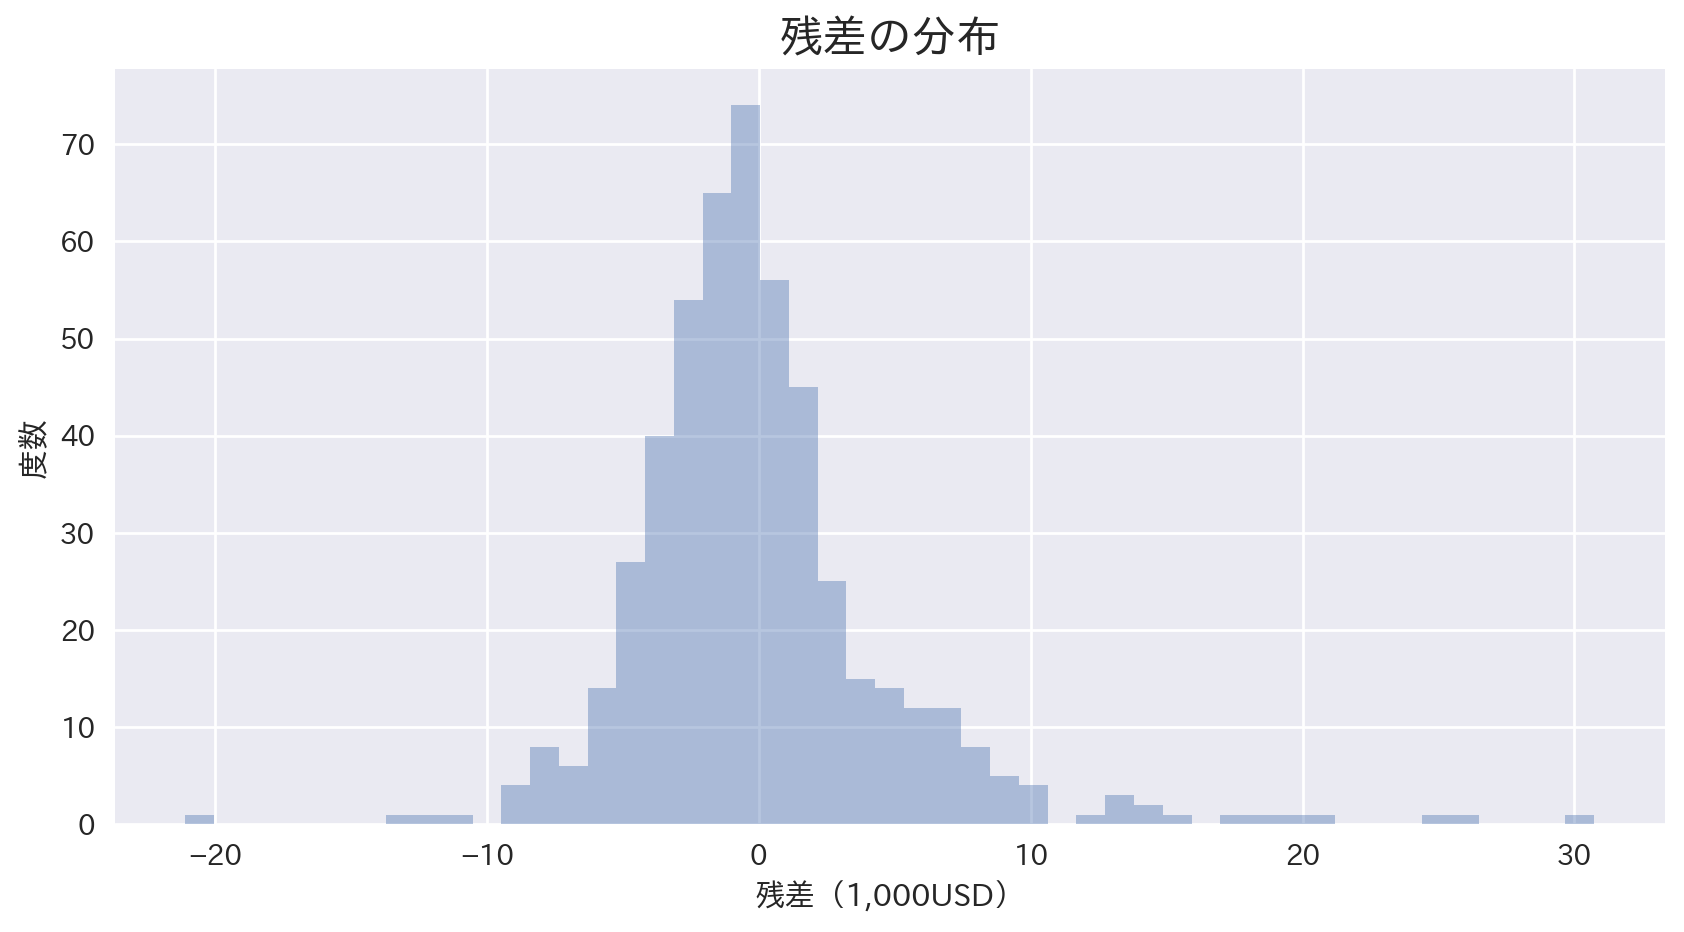

In [37]:
plt.figure(figsize=(10,5),dpi=200)
plt.title("残差の分布",fontsize=16)
plt.xlabel('残差（1,000USD）')
plt.ylabel('度数')
sns.distplot(y-np.dot(X,reg), kde=False, rug=False) 

In [38]:
reg_list=[list(reg)]
itr = 100000

In [39]:
for i in tqdm(range(itr)):
    y_bs = np.dot(X,reg) + np.random.normal(np.mean(y-np.dot(X,reg)),np.std(y-np.dot(X,reg)), len(y))
    reg_bs = solve(np.dot(X.T,X),np.dot(X.T, y_bs).T)
    reg_list.append(list(reg_bs))

Widget Javascript not detected.  It may not be installed or enabled properly.


In [40]:
reg_list=np.array(reg_list)
se_list=[]

for i in range(len(X.T)):
    mean = np.sum(reg_list[:,i])/itr
    se = np.sqrt(np.sum(np.power(reg_list[:,i],2))/itr - mean**2)/np.sqrt(itr)
    se_list.append(se)
    print(f"{df.columns.values[i]}")
    print(f"ブートストラップ前の回帰係数: {reg_list[0,i]}")
    print(f"期待値: {mean}")
    print(f"標準誤差: {se}\n")

CRIM
ブートストラップ前の回帰係数: -0.09162978431218803
期待値: -0.09160797123395845
標準誤差: 0.00010629415478174017

ZN
ブートストラップ前の回帰係数: 0.04867512034091622
期待値: 0.04868455207942011
標準誤差: 4.4724257894318606e-05

INDUS
ブートストラップ前の回帰係数: -0.0037793000553217495
期待値: -0.0034761705311355615
標準誤差: 0.0002009328732949375

CHAS
ブートストラップ前の回帰係数: 2.85636751160414
期待値: 2.856859475158491
標準誤差: 0.002829569025157264

NOX
ブートストラップ前の回帰係数: -2.880779326320651
期待値: -2.840293324314616
標準誤差: 0.010530860506484621

RM
ブートストラップ前の回帰係数: 5.925214318082946
期待値: 5.929176885907985
標準誤差: 0.0009609805551751672

AGE
ブートストラップ前の回帰係数: -0.007224479288684074
期待値: -0.007301024806156122
標準誤差: 4.332649107040938e-05

DIS
ブートストラップ前の回帰係数: -0.967995239838671
期待値: -0.9666641970681601
標準誤差: 0.0006086387314628839

RAD
ブートストラップ前の回帰係数: 0.1704433928675564
期待値: 0.1703113294419639
標準誤差: 0.00020708345442477163

TAX
ブートストラップ前の回帰係数: -0.009389253732672923
期待値: -0.00941025783577058
標準誤差: 1.2208405104549551e-05

PTRATIO
ブートストラップ前の回帰係数: -0.3924256795926667
期待値: -0.391

回帰係数の絶対値と標準誤差の関係を以下に示す。標準誤差が突出して大きい変数は、NOXである。NOXは回帰係数が大きく、説明力が強い一方で、標準誤差が大きく、回帰係数の信頼性は低いと言える。

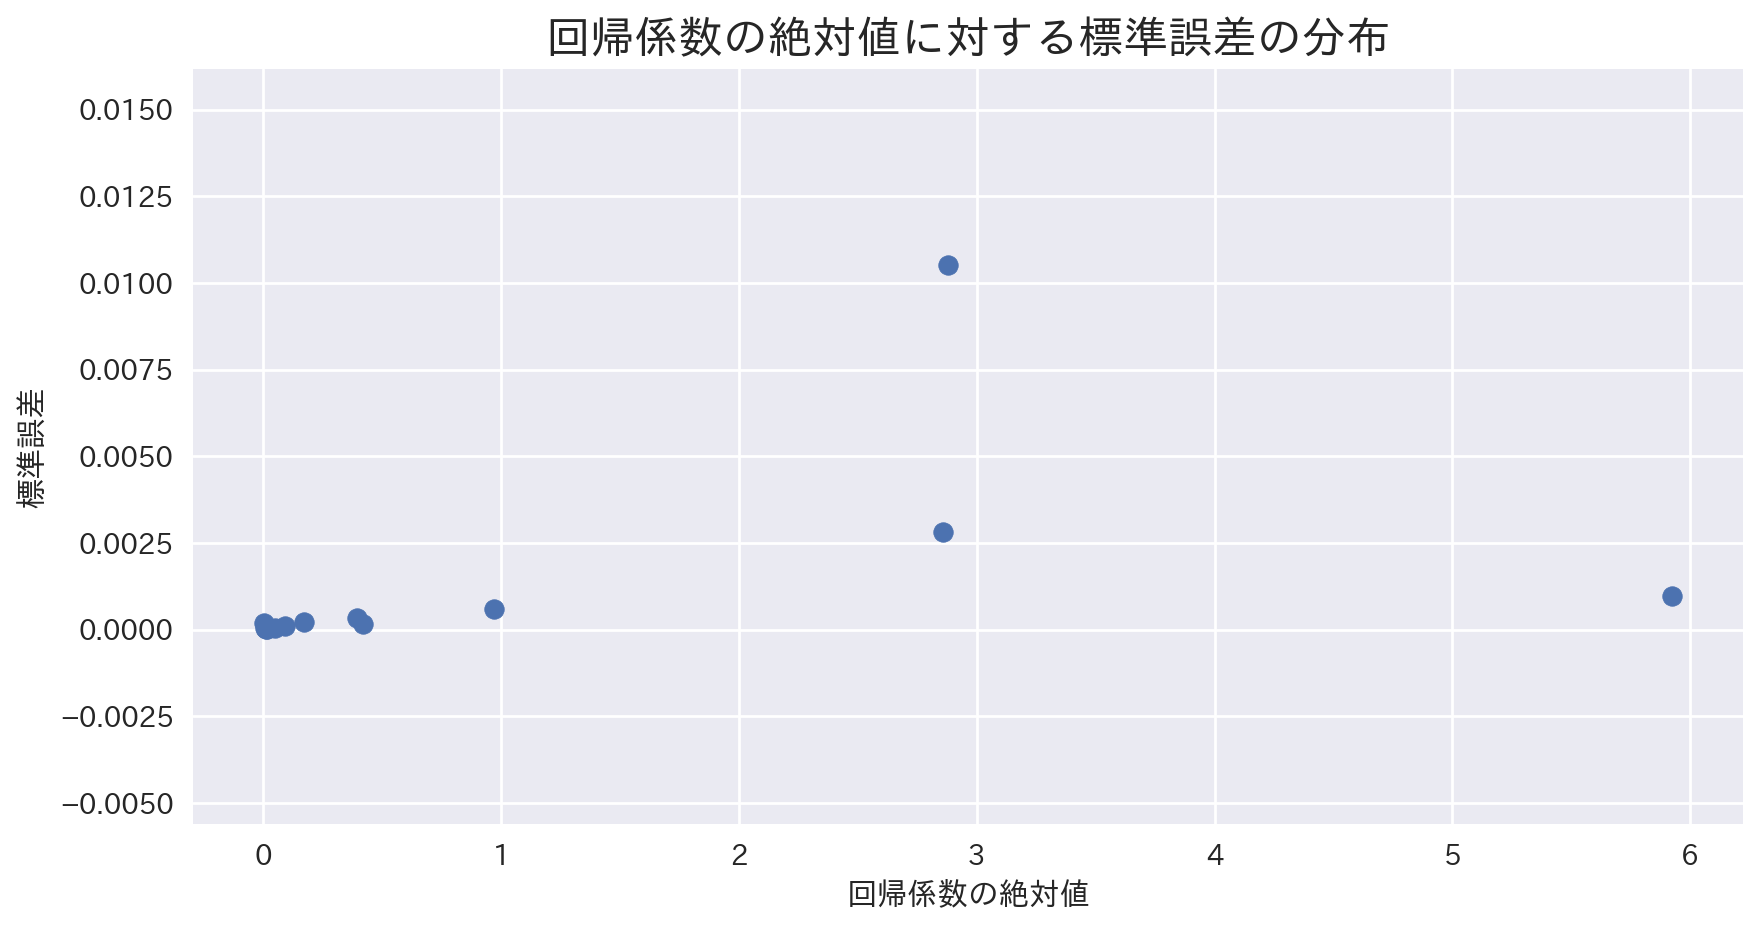

In [41]:
plt.figure(figsize=(10,5),dpi=200)
plt.title("回帰係数の絶対値に対する標準誤差の分布",fontsize=16)
plt.xlabel('回帰係数の絶対値')
plt.ylabel('標準誤差')
plt.scatter(np.abs(reg_list[0,:]), se_list)